In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [5]:
# 데이터셋 인스턴스 생성

data = pd.read_csv("C:/Users/jinwo/Downloads/diabetes.csv")  # CSV 파일 경로

In [6]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [7]:
# 데이터와 타겟 분리
X = data.drop(['Outcome', 'BMI'], axis=1).values
y = data['BMI'].values

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 7), (154, 7), (614,), (154,))

In [12]:
# TensorDataset으로 래핑
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 7), (154, 7), (614,), (154,))

In [18]:
# 회귀 모델 정의
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(7, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RegressionModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
# 학습 루프
model.train()
for epoch in range(50):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Loss: 1065.4115
Epoch 2, Loss: 1003.7696
Epoch 3, Loss: 930.4859
Epoch 4, Loss: 794.8846
Epoch 5, Loss: 644.8343
Epoch 6, Loss: 450.7590
Epoch 7, Loss: 276.8828
Epoch 8, Loss: 162.8853
Epoch 9, Loss: 113.0980
Epoch 10, Loss: 98.4656
Epoch 11, Loss: 93.0331
Epoch 12, Loss: 96.9778
Epoch 13, Loss: 80.1363
Epoch 14, Loss: 77.9246
Epoch 15, Loss: 75.5773
Epoch 16, Loss: 71.7760
Epoch 17, Loss: 68.1978
Epoch 18, Loss: 68.0245
Epoch 19, Loss: 65.9993
Epoch 20, Loss: 65.4582
Epoch 21, Loss: 61.3058
Epoch 22, Loss: 61.5176
Epoch 23, Loss: 58.6409
Epoch 24, Loss: 58.7541
Epoch 25, Loss: 56.7521
Epoch 26, Loss: 55.3876
Epoch 27, Loss: 55.4233
Epoch 28, Loss: 53.9103
Epoch 29, Loss: 51.7278
Epoch 30, Loss: 51.1983
Epoch 31, Loss: 51.1273
Epoch 32, Loss: 50.8518
Epoch 33, Loss: 49.9906
Epoch 34, Loss: 49.8554
Epoch 35, Loss: 50.3038
Epoch 36, Loss: 45.9256
Epoch 37, Loss: 53.1944
Epoch 38, Loss: 45.7945
Epoch 39, Loss: 45.6904
Epoch 40, Loss: 45.7780
Epoch 41, Loss: 43.7494
Epoch 42, Loss

In [24]:
# 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error
model.eval()
preds, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).cpu().numpy()
        preds.extend(outputs)
        actuals.extend(y_batch.numpy())

mse = mean_squared_error(actuals, preds)
print(f"Test MSE: {mse:.4f}")

Test MSE: 63.4366


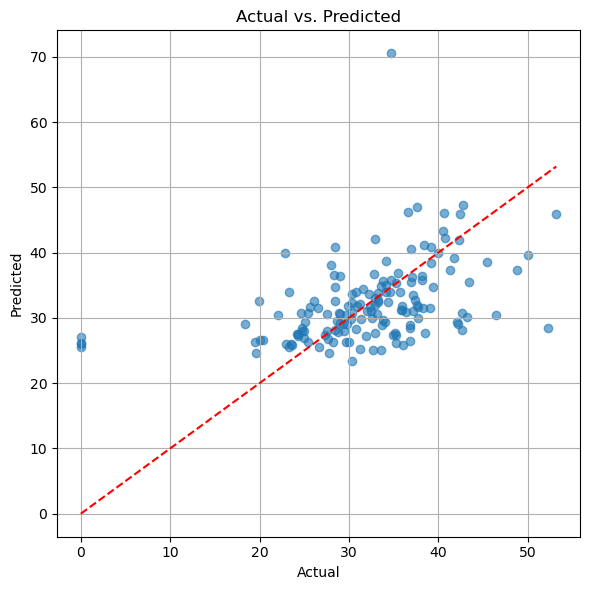

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(actuals, preds, alpha=0.6)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')  
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()